In [15]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from collections import defaultdict
import json

def plot_attention_histogram(attention_scores, layer_num):
    # Flatten the attention scores to a single list
    attention_values = [score.item() for scores in attention_scores for score in scores.flatten()]
    plt.figure(figsize=(10, 6))
    plt.hist(attention_values, bins=50, alpha=0.75)
    plt.title(f'Attention Score Distribution - Layer {layer_num}')
    plt.xlabel('Attention Scores')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


### TODO: Load in datasets to see how to sparsify v for 
- One coding dataset
- One wiki dataset
- One general internet dataset
- One dialogue/assistant dataset

### TODO: Report the percentage of logits needed for cumsum to be 80, 90, 95, 99%
- if you keep the top n% for n in 1, 5, 10, 20, what are their percentages
### TODO: Run metrics across different sequence lengths
- Find max seq length and use prefixes of it
  -  also filter out sequences under a certain length
- report metrics at intermediate sequence lengths
  - ex). on __ sequences, these are the metrics for __ sequence length
- Track worst case (sparsity) - when the data is not sparse b/c all the logits are close
  - more evenly distrubuted logits


In [2]:
class DatasetTypes(Enum):
    WIKI = ('wikitext', 'wikitext-2-raw-v1')
    INTERNET = 'Skylion007/openwebtext'
    CODE = 'bigcode/starcoderdata'
    ASSISTANT = 'HuggingFaceH4/ultrachat_200k'

def get_dataset (dataset_type: DatasetTypes):
    if dataset_type == DatasetTypes.WIKI:
        return load_dataset(dataset_type.value[0], dataset_type.value[1], streaming=True)
    return load_dataset(dataset_type.value, streaming=True)


In [3]:
dataset = get_dataset(DatasetTypes.WIKI)

In [4]:
# Load tokenizer and model
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)

In [54]:
num_of_samples = 1

In [6]:
stream = iter(dataset['train'])

In [50]:
min_seq_len = 100
top_ks = [1, 5, 10, 20]
metric_cumsums = [80, 90, 95, 99]
samples_metrics = list()


In [53]:
# Encode input and create tensors
for i in range(num_of_samples):
    input_text = next(stream)['text']
    
    while len(input_text) < min_seq_len:
        input_text = next(stream)['text']

    print(input_text)

    inputs = tokenizer(input_text, return_tensors="pt")
    
    metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0))))
    
    # Run the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the attentions
    attentions = outputs.attentions  # Tuple of tensors: one for each layer

    # make a tril matrix of size [sequence_length, sequence_length]
    sequence_length = attentions[0].shape[-1]
    print(sequence_length)

    for h in range(len(attentions)):
        for l, layer_attention in enumerate(attentions):
            att = layer_attention[0, h, -1, :].sort().values
            reverse_att = att.flip(0)
            total_prob = att.cumsum(0)
            reverse_total_prob = reverse_att.cumsum(0)
            for k, total_sum in zip(top_ks, metric_cumsums):
                k_percentile, desired_sum = k / 100, total_sum / 100
                
                min_elements = torch.nonzero(reverse_total_prob > desired_sum)[0]

                top_percentile_prob = total_prob[-int(k_percentile * sequence_length)]

                prev_precentile = metrics[l][h]["top_percentile_prob"]
                prev_total_sum = metrics[l][h][ "min_logits_for_cumsum"]
                prev_precentile[k] = 1 - top_percentile_prob.item()
                prev_total_sum[f"{total_sum}%"] = 1 + min_elements.item()
    samples_metrics.append(metrics) 

print(json.dumps(samples_metrics[0][0], indent=4))

 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Character designer Raita Honjou and composer Hitoshi Sakimoto both returned from previous entries , along with Valkyria Chronicles II director Takeshi Ozawa . A large team of writers handled the script . The game 's opening theme was sung by May 'n . 

107
 It met with positive sales in Japan , and was praised by both Japanese and western critics . After release , it received downloadable content , along with an expanded edition in November of that year . It was also adapted into manga and an original video animation series . Due to low sales of Valkyria Chronicles II , Valkyria Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 . Media.Vision woul

In [ ]:
ten_percent = int(.1 * sequence_length)
total_prob[-ten_percent]

tensor(0.3880)

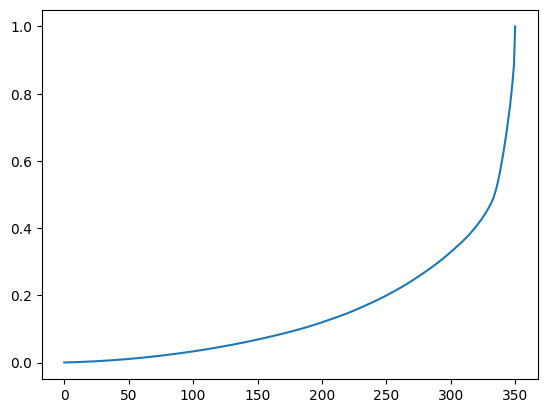

In [128]:
att = layer_attention[0][0][-1].sort().values
att, att.shape
plt.plot(att.cumsum(0))

In [129]:
total_prob = att.cumsum(0)
torch.nonzero(total_prob > .1)[0]

tensor([184])

111 elements needed to cumsum > .1

In [130]:
ten_percent = int(.1 * sequence_length)
total_prob[-ten_percent]

tensor(0.3880)

The top 10% of the sequence makes up ~68% of the sum (in this example)

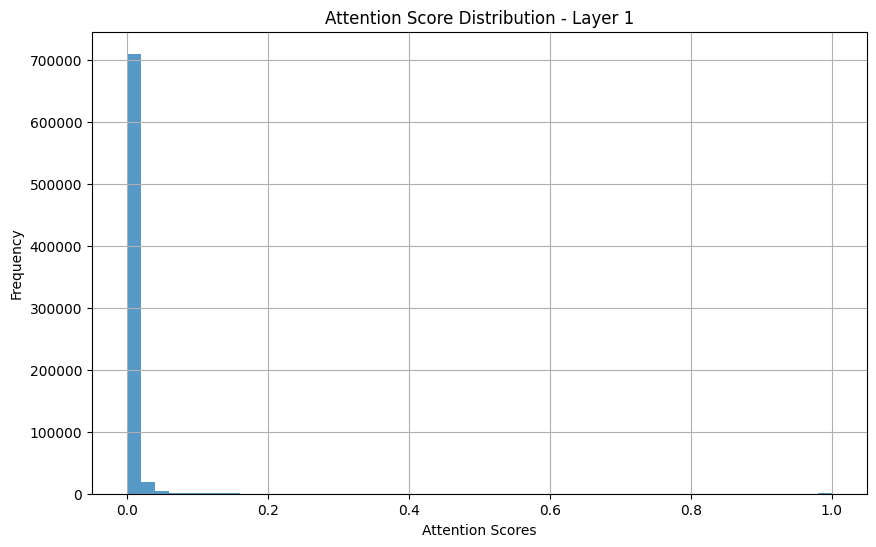

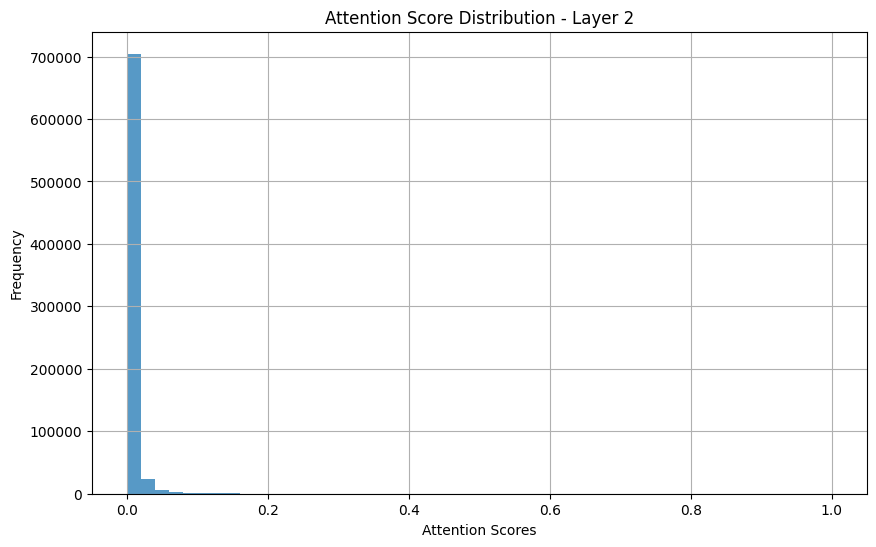

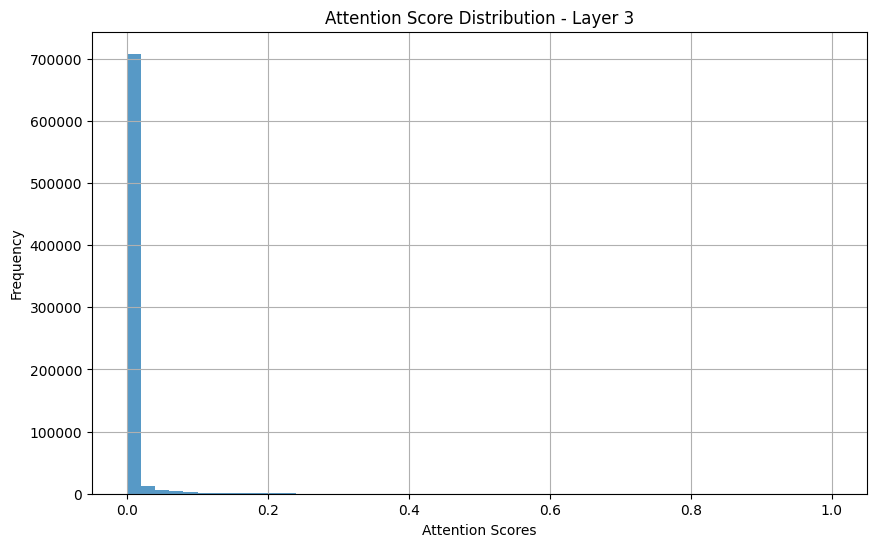

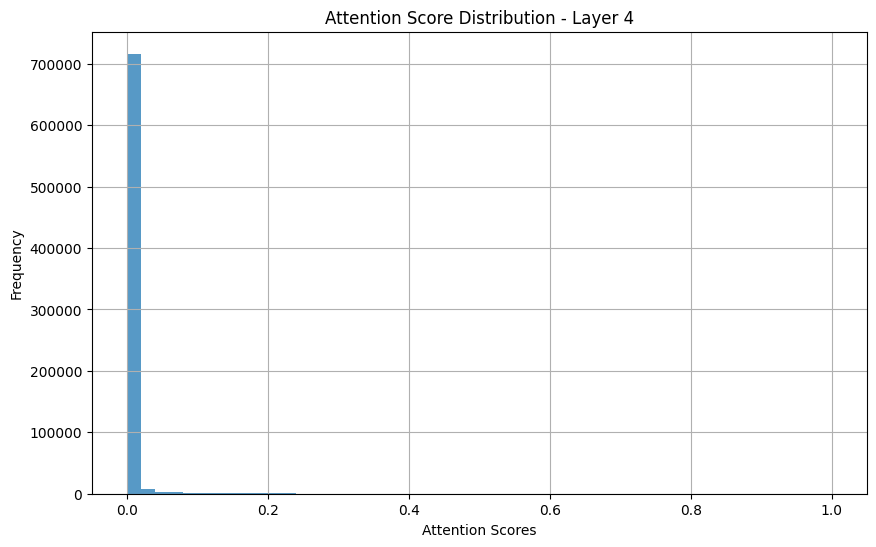

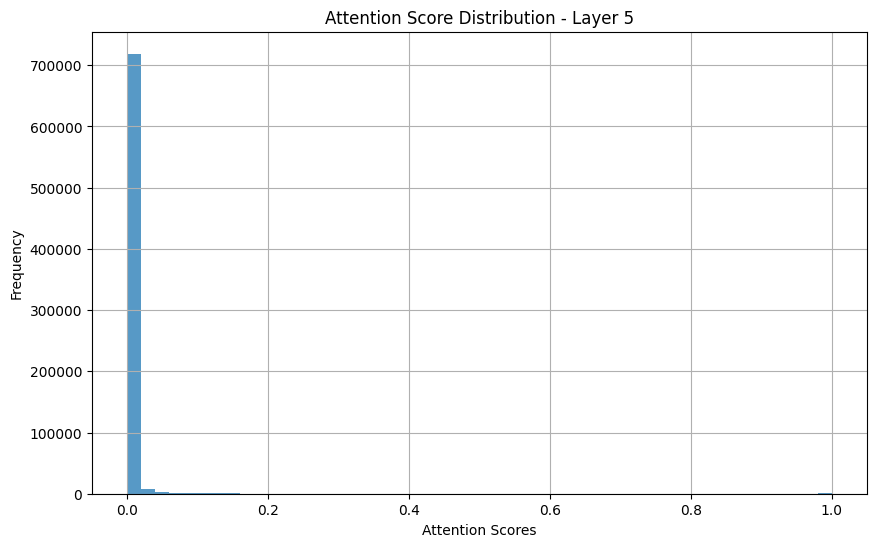

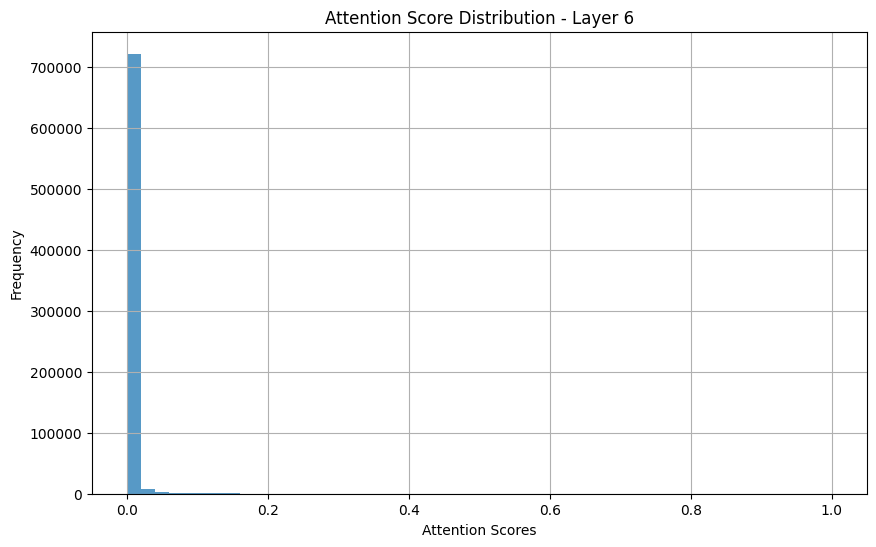

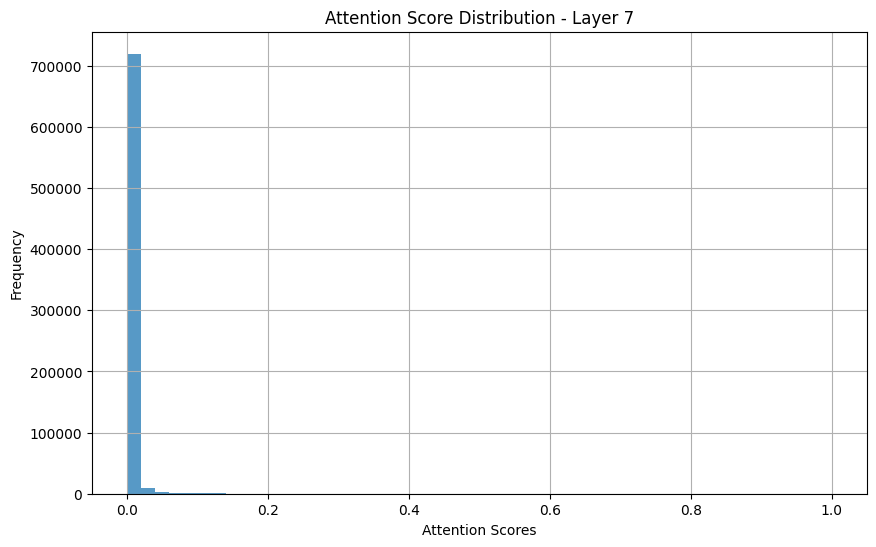

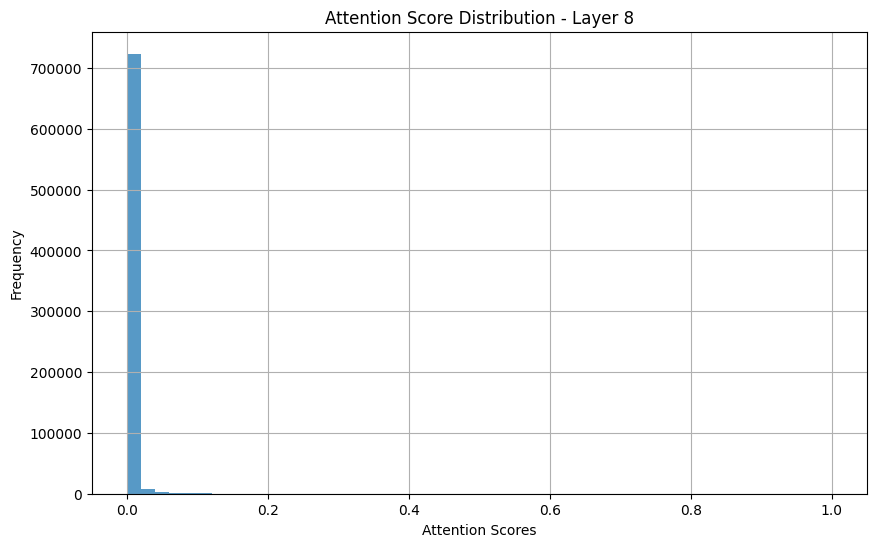

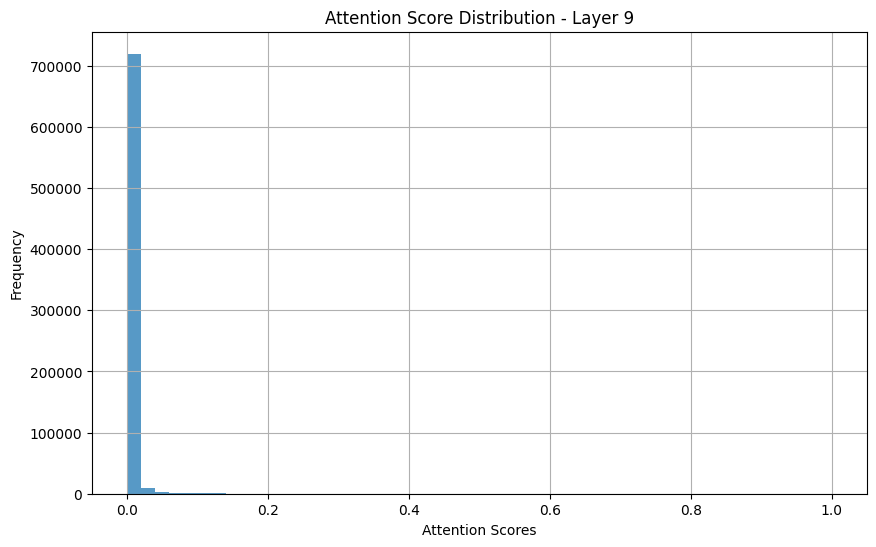

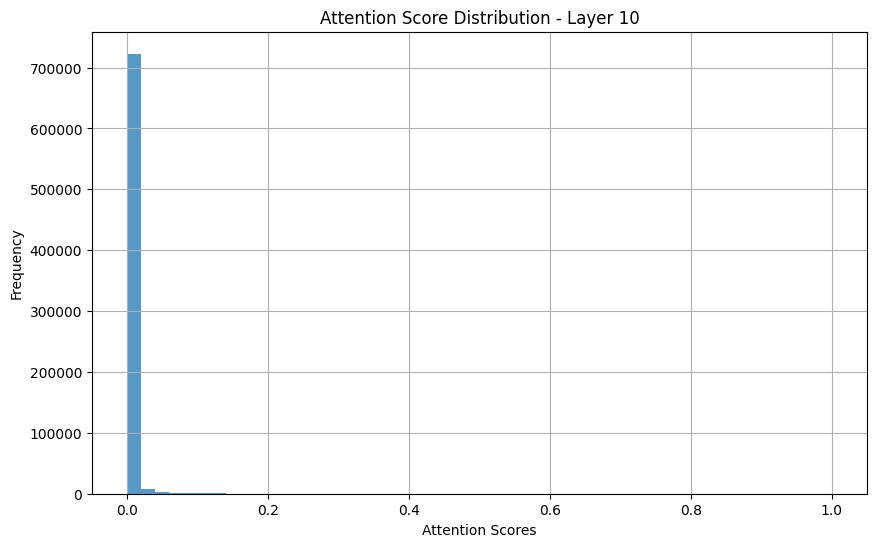

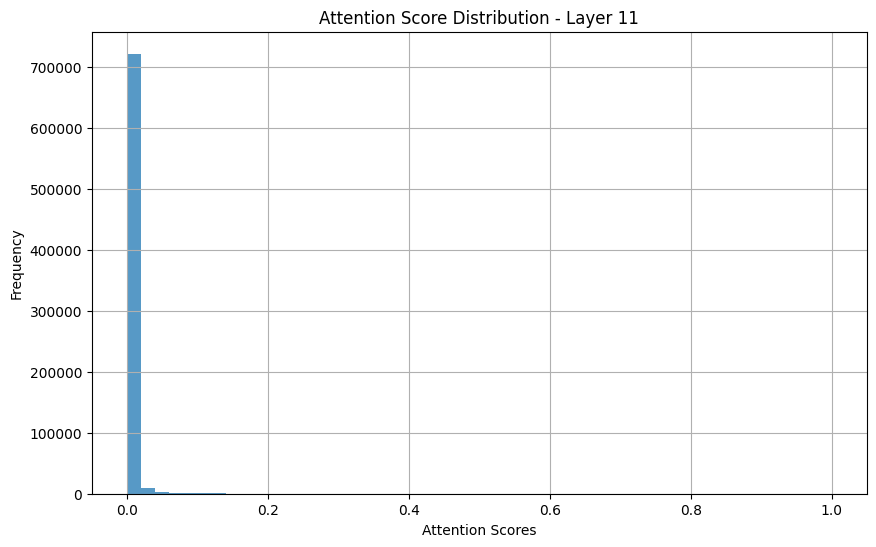

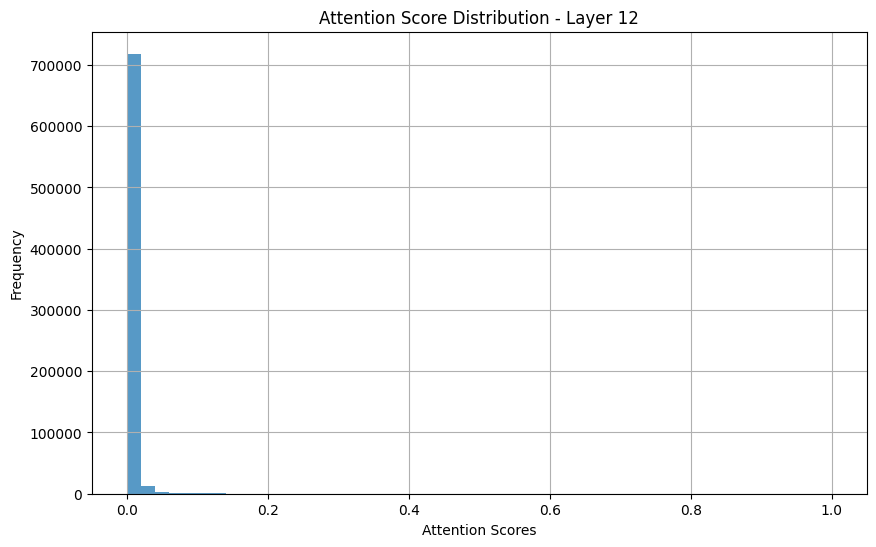

In [127]:
# Process each layer's attention scores
for l, layer_attention in enumerate(attentions):
    # layer_attention is of shape [batch_size, num_heads, sequence_length, sequence_length]
    # For histogram, we consider all heads and all positions
    # plot_attention_histogram(layer_attention[0], i + 1)'

    # only plotting the first batch (since only one sequence) and in tril matrix
    att = layer_attention[0, :, mask]

    plot_attention_histogram(att, l + 1)